# Import Module

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, Flatten, InputLayer

import pickle



# Import Data

Data saham yang digunakan adalah data sama Bank Mandiri, dari tanggal 01/01/2018 sampai 01/12/2023

In [ ]:
data = pd.read_csv("BMRI.JK.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-01,4000.0,4000.0,4000.0,4000.0,3156.422852,0
1,2018-01-02,3987.5,4025.0,3912.5,3925.0,3097.239746,59351600
2,2018-01-03,3925.0,3925.0,3825.0,3850.0,3038.056885,84278000
3,2018-01-04,3875.0,3912.5,3862.5,3912.5,3087.376221,90123000
4,2018-01-05,3862.5,3925.0,3862.5,3912.5,3087.376221,75378600


In [ ]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1470,2023-11-27,5900.0,5925.0,5875.0,5900.0,5900.0,39719300
1471,2023-11-28,5900.0,5925.0,5875.0,5900.0,5900.0,58255800
1472,2023-11-29,5850.0,5925.0,5825.0,5850.0,5850.0,36796600
1473,2023-11-30,5850.0,5925.0,5825.0,5850.0,5850.0,117365000
1474,2023-12-01,5850.0,5900.0,5825.0,5900.0,5900.0,31365100


# Explore Data

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1475 entries, 0 to 1474
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1475 non-null   object 
 1   Open       1475 non-null   float64
 2   High       1475 non-null   float64
 3   Low        1475 non-null   float64
 4   Close      1475 non-null   float64
 5   Adj Close  1475 non-null   float64
 6   Volume     1475 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 80.8+ KB


In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1475 entries, 0 to 1474
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1475 non-null   datetime64[ns]
 1   Open       1475 non-null   float64       
 2   High       1475 non-null   float64       
 3   Low        1475 non-null   float64       
 4   Close      1475 non-null   float64       
 5   Adj Close  1475 non-null   float64       
 6   Volume     1475 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 80.8 KB


## Ploting data

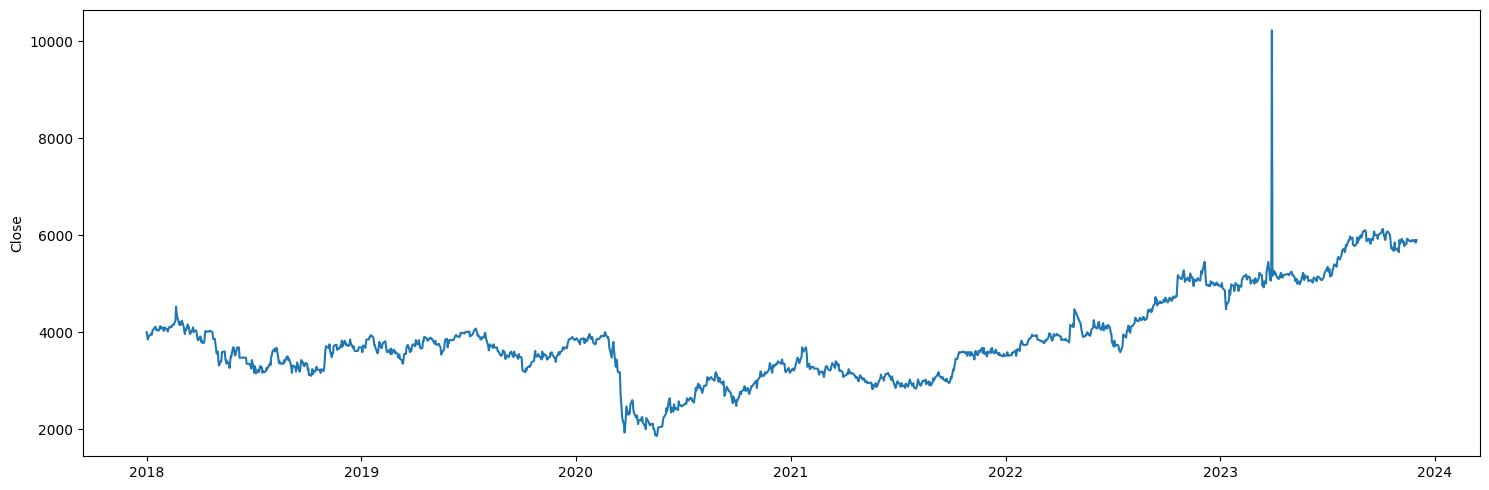

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(data['Date'],data['Close'],label="Close")
plt.ylabel('Close')
plt.xlabel(None)
plt.tight_layout()
plt.show()

## Moving Average dari data Saham

In [ ]:
ma_day = [20, 30, 60, 120]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    data[column_name] = data['Close'].rolling(ma).mean()

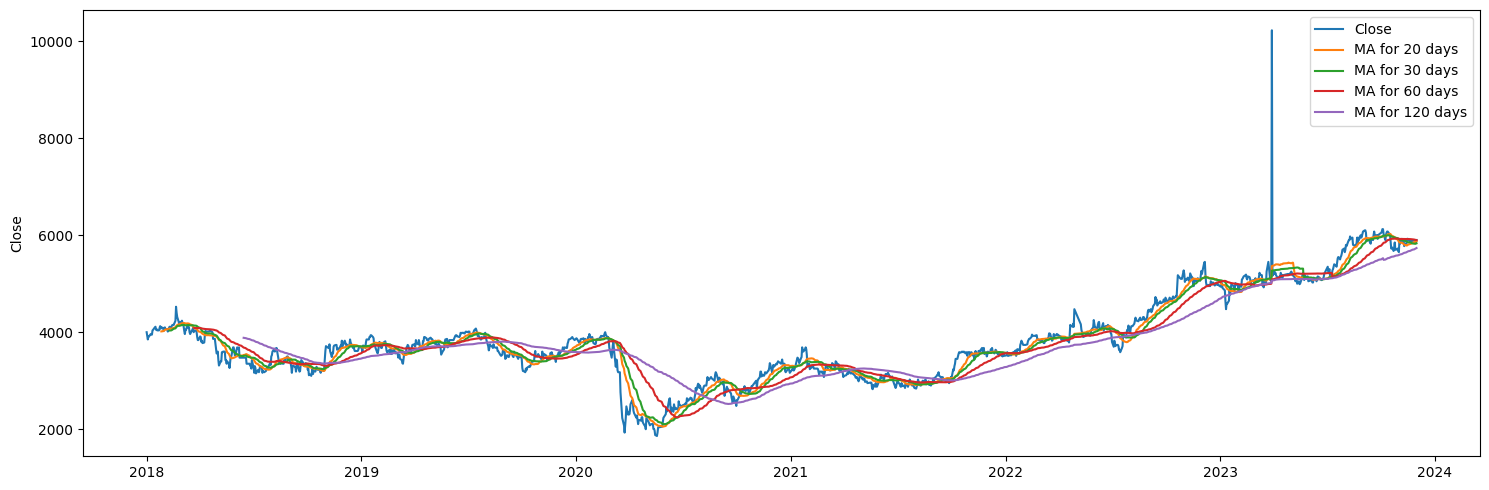

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(data['Date'],data['Close'],label="Close")
for ma in ma_day:
    plt.plot(data['Date'],data[f"MA for {ma} days"],label=f"MA for {ma} days")

plt.ylabel('Close')
plt.legend()
plt.tight_layout()
plt.show()

## Perubahan perharinya

Disini kita akan melihat persentase perubahan data

In [ ]:
data['Daily change'] = data['Close'].pct_change()

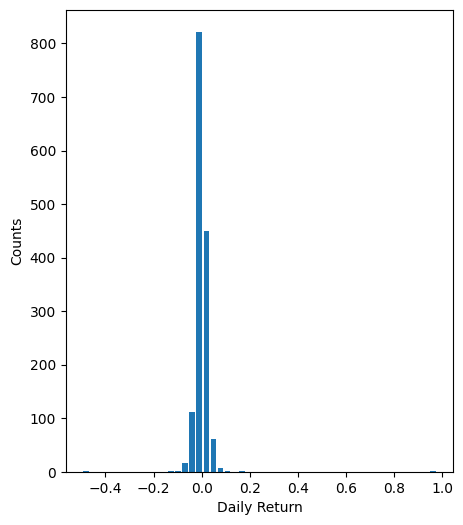

In [ ]:
plt.figure(figsize=(5, 6))
data['Daily change'].hist(bins=50,rwidth=0.8,grid=False)
plt.xlabel('Daily Return')
plt.ylabel('Counts')
plt.show()

# Preprocessing Data

## Pengubahan Data yang mengalami lonjakan ekstrim pada grafik



Perhatikan bahwa ada data yang melonjak sangat tinggi di sekitar tahun 2023. Hal ini akan kita hilangkan dan diganti dengan harga saham kemarinnya karena model LSTM sangat berpengaruh dengan lonjakan seperti itu, yang mana jika tidak dihilangkan pada saat training LSTM akan berpusat di lonjakan itu yang mana menyebabkan hasilnya tidak bagus.

In [ ]:
data[data['Close'] >= 8000]

,Date,Open,High,Low,Close,Adj Close,Volume,MA for 20 days,MA for 30 days,MA for 60 days,MA for 120 days,Daily change
1314,2023-03-30,10350.0,10400.0,10225.0,10225.0,10225.0,48593100,5364.375,5268.333333,5088.125,5063.541667,0.975845


In [ ]:
problem_index = list(data[data['Close'] >= 8000].index)
for index in problem_index:
    data.loc[index,'Close'] = data.loc[index-1,'Close']
    data.loc[index,'Adj Close'] = data.loc[index-1,'Adj Close']

### Explore ulang data

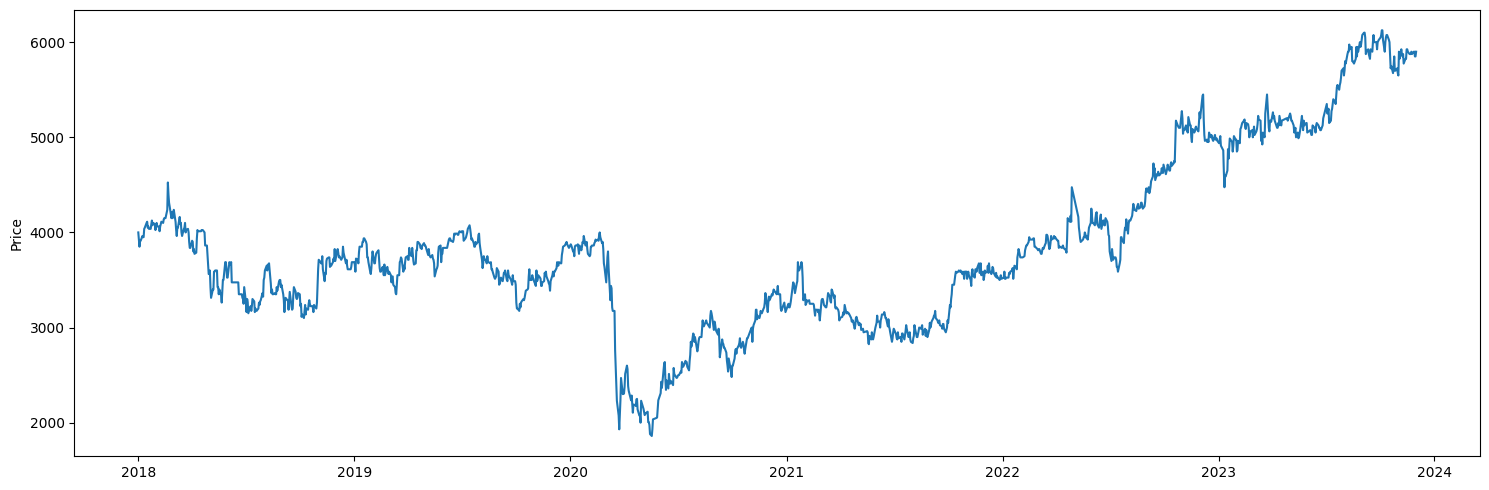

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(data['Date'],data['Close'],label="Close")
plt.ylabel('Price')
plt.xlabel(None)
plt.tight_layout()
plt.show()

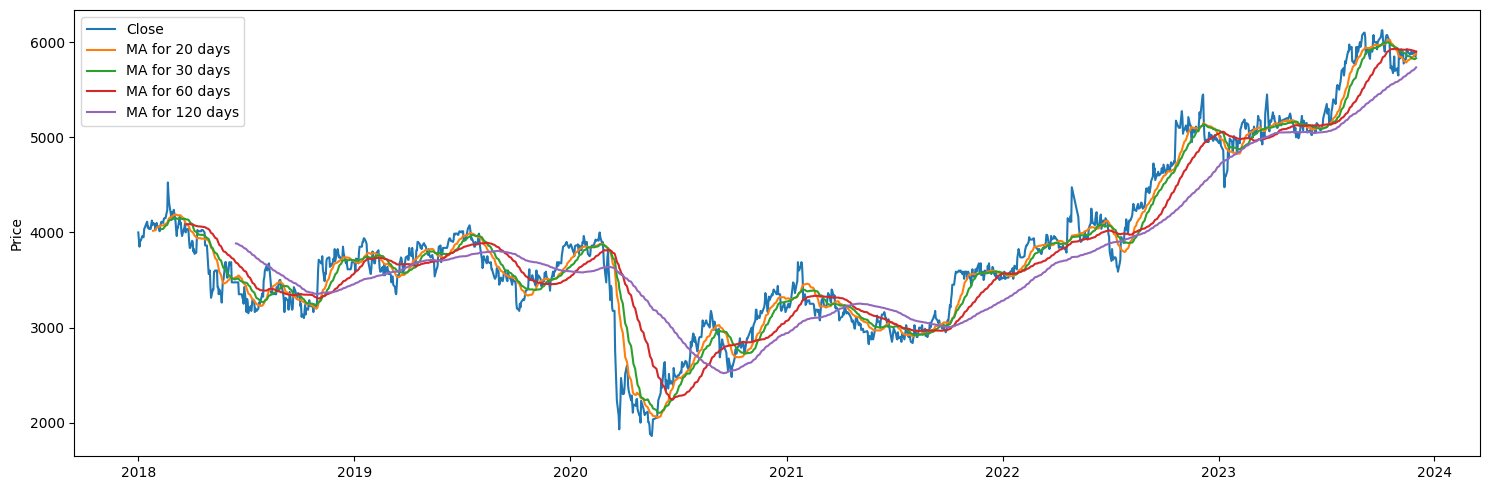

In [ ]:
ma_day = [20, 30, 60, 120]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    data[column_name] = data['Close'].rolling(ma).mean()


plt.figure(figsize=(15, 5))
plt.plot(data['Date'],data['Close'],label="Close")
for ma in ma_day:
    plt.plot(data['Date'],data[f"MA for {ma} days"],label=f"MA for {ma} days")

plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

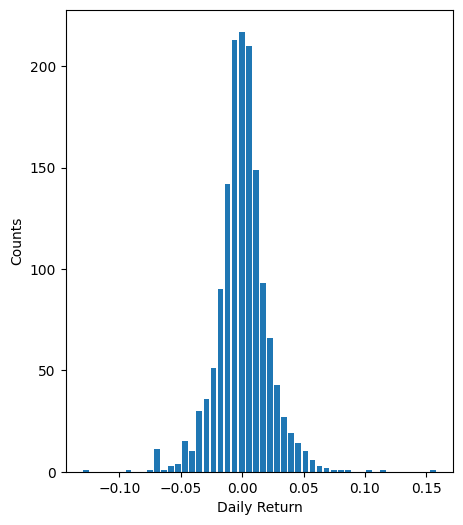

In [ ]:
data['Daily change New'] = data['Close'].pct_change()

plt.figure(figsize=(5, 6))
data['Daily change New'].hist(bins=50,rwidth=0.8,grid=False)
plt.xlabel('Daily Return')
plt.ylabel('Counts')
plt.show()

## Membuat Dataset untuk LSTM

### Close Data

Hanya menggunakan data Close Price

In [ ]:
data_lstm = data.filter(['Close'])
data_lstm = data_lstm.values
data_lstm

array([[4000.],
       [3925.],
       [3850.],
       ...,
       [5850.],
       [5850.],
       [5900.]])

### Scaling data

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data_lstm = scaler.fit_transform(data_lstm)

scaled_data_lstm

array([[0.5017585 ],
       [0.48417351],
       [0.46658851],
       ...,
       [0.93552169],
       [0.93552169],
       [0.94724502]])

In [ ]:
with open('scaler2.pkl', 'wb') as file:
    pickle.dump(scaler, file)

### Create Training Dataset

In [ ]:
def create_data_lstm(data,train_size,days=60):
    '''
        data : 2D array
        train_size : float -> value in interval (0,1]
        days : int -> banyaknya data hari yang diinginkan untuk memprediksi 1 hari berikutnya
    '''
    if train_size <= 0 or train_size > 1:
        raise ValueError("train_size should be positive and a float in the (0, 1) range")

    x_train,y_train = [],[]
    x_test, y_test = [],[]
    days = int(days)

    train_length = int(np.floor(len(data) * train_size))
    test_length = len(data) - train_length

    for i in range(days,len(data)):
        if i < train_length:
            x_train.append(data[i-days:i,0])
            y_train.append(data[i,0])
        else:
            x_test.append(data[i-days:i,0])
            y_test.append(data[i,0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test, y_test = np.array(x_test), np.array(y_test)
    return x_train, y_train, x_test, y_test

In [ ]:
look_back_days = 10
x_train, y_train, x_test, y_test = create_data_lstm(scaled_data_lstm,train_size = 0.9,days=look_back_days)

In [ ]:
print(x_test.shape)
print(x_train.shape)

(148, 10)
(1317, 10)


# Model LSTM

## Membuat model LSTM

In [ ]:
from tensorflow.keras.optimizers import Adam

EPOCHS = 300
BATCH_SIZE = 32

In [ ]:
def lstm_model(input_shape):
    model = Sequential()

    model.add(InputLayer(input_shape=input_shape))

    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(64,activation='relu'))

    # Output Layer
    model.add(Dense(1,activation='linear'))

    opt = Adam(learning_rate=1e-4)
    model.compile(optimizer=opt, loss='mean_absolute_error')

    return model

In [ ]:
input_shape = (x_train.shape[1],1)
model_lstm = lstm_model(input_shape=input_shape)
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 206465 (806.50 KB)
Trainable params: 20646

### Training Model

In [ ]:
history = model_lstm.fit(x_train,y_train,
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         verbose=1)

Epoch 1/300
42/42 [==============================] - 7s 34ms/step - loss: 0.3205
Epoch 2/300
42/42 [==============================] - 1s 33ms/step - loss: 0.0610
Epoch 3/300
42/42 [==============================] - 1s 32ms/step - loss: 0.0406
Epoch 4/300
42/42 [==============================] - 2s 46ms/step - loss: 0.0373
Epoch 5/300
42/42 [==============================] - 1s 34ms/step - loss: 0.0349
Epoch 6/300
42/42 [==============================] - 2s 42ms/step - loss: 0.0343
Epoch 7/300
42/42 [==============================] - 3s 61ms/step - loss: 0.0342
Epoch 8/300
42/42 [==============================] - 3s 61ms/step - loss: 0.0323
Epoch 9/300
42/42 [==============================] - 2s 53ms/step - loss: 0.0329
Epoch 10/300
42/42 [==============================] - 1s 33ms/step - loss: 0.0327
Epoch 11/300
42/42 [==============================] - 1s 33ms/step - loss: 0.0329
Epoch 12/300
42/42 [==============================] - 1s 33ms/step - loss: 0.0317
Epoch 13/300
42/42 [=====

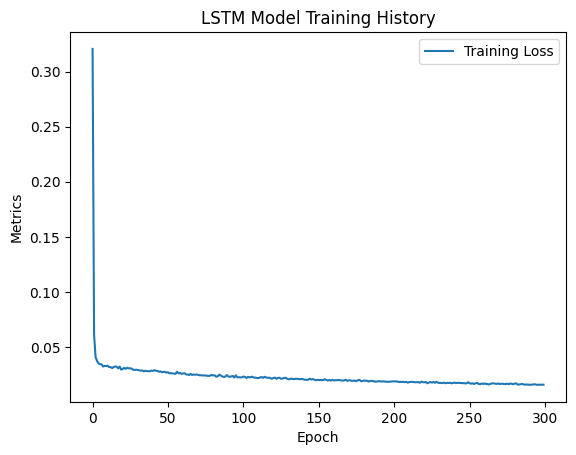

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('LSTM Model Training History')
plt.legend()
plt.show()

## Testing Model

In [ ]:
y_pred = model_lstm.predict(x_test)

5/5 [==============================] - 1s 11ms/step


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Hasil MAE scaled data adalah {mae:.5f}")
print(f"Hasil MSE scaled data adalah {mse:.5f}")
print(f"Hasil RMSE scaled data adalah {rmse:.5f}")

Hasil MAE scaled data adalah 0.01500
Hasil MSE scaled data adalah 0.00037
Hasil RMSE scaled data adalah 0.01934


### Plot

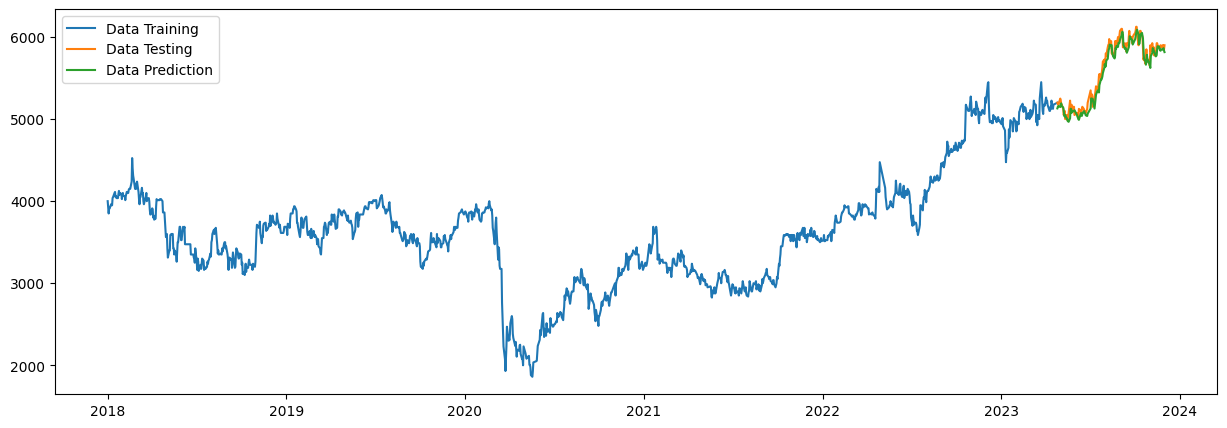

In [ ]:
y_pred_inv = scaler.inverse_transform(y_pred)
y_pred_inv = y_pred_inv.reshape(-1)

plt.figure(figsize=(15, 5))
plt.plot(data.loc[:len(x_train)+look_back_days,"Date"],data.loc[:len(x_train)+look_back_days,"Close"],label = 'Data Training')
plt.plot(data.loc[len(x_train)+look_back_days:,"Date"],data.loc[len(x_train)+look_back_days:,"Close"],label = 'Data Testing')
plt.plot(data.loc[len(x_train)+look_back_days:,"Date"],y_pred_inv,label = 'Data Prediction')
plt.legend()
plt.show()

## Saving the Model

In [ ]:
model_lstm.save("lstm_predict_tomorrow.keras")
model_lstm.save_weights("lstm_pred_tomorrow_weights.h5")